In [1]:
import cv2
import json
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.pyplot import figure
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [2]:
title = {
    0: "Classe Animal",
    1: "Classe Vazio",
}
alpha = [title[0], title[1]]

In [3]:
def preprocess_confidence(df):
    df = df.rename(columns={"pred_confidence": "pred_confidence_0"})
    df['pred_confidence_1'] = df.pred_confidence_0.map(lambda a: 1-a)
    return df

def get_accuracy(threshold, df, _class):
    tmp = df[df['pred_confidence_' + str(_class)] >= threshold]

    corrects = len(tmp[tmp.pred == tmp.real])
    all = tmp.__len__()

    if all == 0:
        return threshold, None
    else:
        accuracy = corrects/all
        return threshold, accuracy

def plot_model_results(df, name, color, _class):
    thresholds = [0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    # thresholds = [0.5, 0.53, 0.56, 0.59, 0.60]
    x = []
    y = []
    for i in thresholds:
        threshold, accuracy = get_accuracy(i, df, _class)
        x.append(threshold)
        y.append(accuracy)

    plt.plot(x, y, label=name, color=color)
    plt.xlabel("Threshold (%)")
    plt.ylabel("Acurácia (%)")

def show_confusion_matrix(real, pred, name):
    conf_matrix = confusion_matrix(y_true=real, y_pred=pred)
    fig, ax = plt.subplots()
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    ax.set_xticklabels(['']+alpha)
    ax.set_yticklabels(['']+alpha)

    plt.xlabel('Predição', fontsize=18)
    plt.ylabel('Real', fontsize=18)
    plt.title(name, fontsize=14)
    plt.show()

def general_evaluation(models, report=False, classes=[1, 0]):
    for name in models.keys():
        print('---------> GENERAL EVALUATION - MODEL:', name)
        df = preprocess_confidence(pd.read_csv(models[name]))
        if not classes:
            print('All', accuracy_score(df.real, df.pred))
        else:
            for i in classes:
                _filter = df[df.real == i]
                print(title[i], accuracy_score(_filter.real, _filter.pred))
        if report:
            print(classification_report(df.real, df.pred, target_names=alpha), '\n\n')

def confusion_matrix_evaluation(models):
    for name in models.keys():
        print('---------> CONFUSION MATRIX - MODEL:', name)
        df = preprocess_confidence(pd.read_csv(models[name]))
        show_confusion_matrix(df.real, df.pred, name)

def threshold_evaluation(models, _class):
    color = 0
    palette = sns.color_palette(None, len(models.keys()))
    for name in models.keys():
        df = preprocess_confidence(pd.read_csv(models[name]))
        plot_model_results(df, name, palette[color], _class)
        color += 1
    plt.title(title[_class])
    plt.legend()
    plt.show()
    
def process_filename(img_dir, filenames):
    return [i.replace(img_dir, '').replace('\n', '') for i in filenames]

#### Ours data results

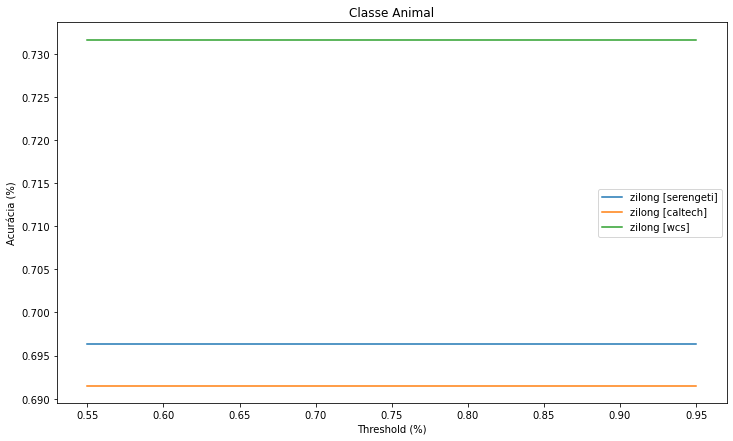

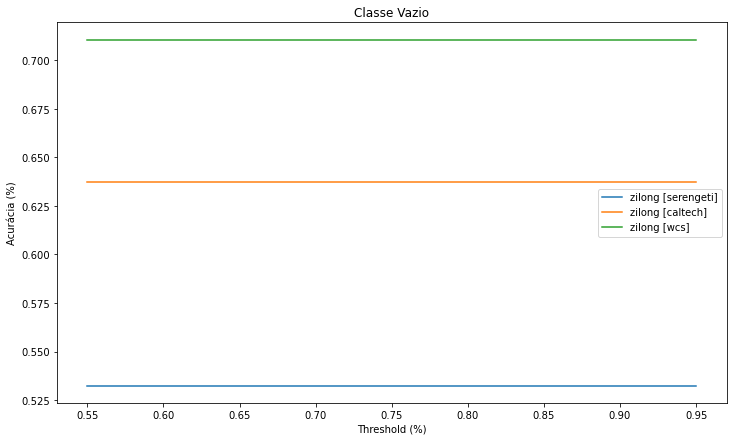

In [10]:
plt.rcParams["figure.figsize"] = (12, 7)
# treino com pares de imagens não agrupadas por tempo

models = {}

datasets = ['serengeti']
models_names = ['mobilenetv2', 'resnet50', 'efficientnetb0']

for d in datasets:
    for m in models_names:
        models[f'{m}-siamese [{d}]'] = f'/home/luiz/experiments/siamese-network-on-camera-trap/tmp/test_data/eval_test_{m}_siamese_{d}_(tag_no_serengeti_weights)_256.csv'
        models[f'{m} [{d}]'] = f'/home/luiz/experiments/siamese-network-on-camera-trap/tmp/test_data/eval_test_{m}_{d}_(tag_no_serengeti_weights)_256.csv'

datasets = ['caltech', 'wcs']
models_names = ['mobilenetv2', 'resnet50', 'efficientnetb0']

for d in datasets:
    for m in models_names:
        models[f'{m}-siamese [{d}]'] = f'/home/luiz/experiments/siamese-network-on-camera-trap/tmp/test_data/eval_test_{m}_siamese_{d}_(tag_serengeti_weights)_256.csv'
        models[f'{m} [{d}]'] = f'/home/luiz/experiments/siamese-network-on-camera-trap/tmp/test_data/eval_test_{m}_{d}_(tag_serengeti_weights)_256.csv'

datasets = ['serengeti', 'caltech', 'wcs']
for d in datasets:
    models[f'zilong [{d}]'] = f'/home/luiz/experiments/Zilong/output/{d}/test.csv'

threshold_evaluation(models, 0)
threshold_evaluation(models, 1)

In [11]:
def view_predicts(model_path, images_path, num = 10):
    df = pd.read_csv(model_path)
    for i, idx in enumerate(df.sample(num).index):
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        element = df.iloc[idx]
        print(f"index: {idx} {element['file_name_x']} {element['file_name_y']}")
        img1 = np.array(Image.open(images_path + element['file_name_x']))
        img2 = np.array(Image.open(images_path + element['file_name_y']))
        
        ax[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB).astype(np.uint8))
        ax[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB).astype(np.uint8))
        ax[0].title.set_text(f"""index: {idx}\nreal: {title[element['real']]} - pred: {title[element['pred']]}""")

# dataset_name = "caltech"
# images_path = f"/data/luiz/dataset/{dataset_name}_images/"
# model_path = models[f'resnet50 (siamese) /{dataset_name}']

# view_predicts(model_path, images_path)

In [11]:
general_evaluation(models=models, report=True, classes=[1, 0])

---------> GENERAL EVALUATION - MODEL: zilong [serengeti]
Classe Vazio 0.5261794871794871
Classe Animal 0.7016333333333333
               precision    recall  f1-score   support

Classe Animal       0.53      0.70      0.61     30000
 Classe Vazio       0.70      0.53      0.60     39000

     accuracy                           0.60     69000
    macro avg       0.61      0.61      0.60     69000
 weighted avg       0.63      0.60      0.60     69000
 


---------> GENERAL EVALUATION - MODEL: zilong [caltech]
Classe Vazio 0.7532307692307693
Classe Animal 0.5632
               precision    recall  f1-score   support

Classe Animal       0.64      0.56      0.60      5000
 Classe Vazio       0.69      0.75      0.72      6500

     accuracy                           0.67     11500
    macro avg       0.66      0.66      0.66     11500
 weighted avg       0.67      0.67      0.67     11500
 


---------> GENERAL EVALUATION - MODEL: zilong [wcs]
Classe Vazio 0.8073846153846154
Classe Anima

---------> CONFUSION MATRIX - MODEL: mobilenetv2-siamese [serengeti]


/tmp/ipykernel_4453/1262082654.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+alpha)
/tmp/ipykernel_4453/1262082654.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+alpha)


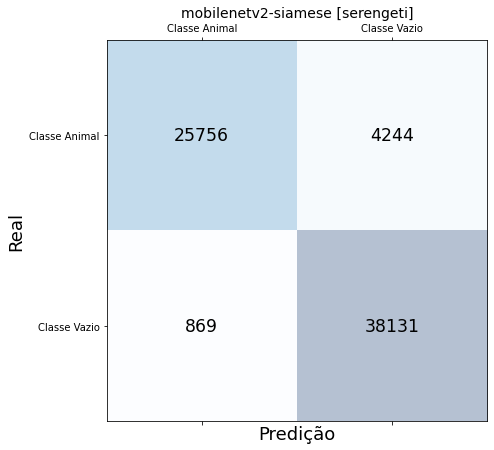

---------> CONFUSION MATRIX - MODEL: mobilenetv2 [serengeti]


/tmp/ipykernel_4453/1262082654.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+alpha)
/tmp/ipykernel_4453/1262082654.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+alpha)


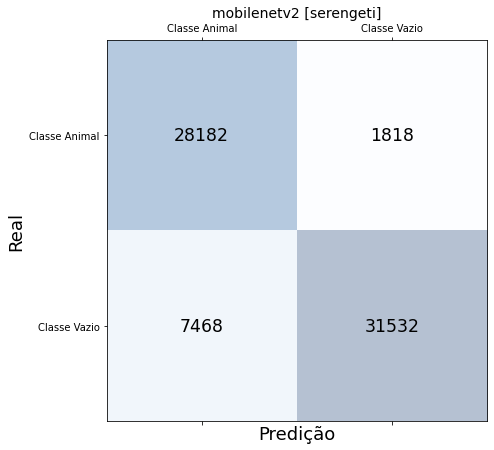

---------> CONFUSION MATRIX - MODEL: resnet50-siamese [serengeti]


/tmp/ipykernel_4453/1262082654.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+alpha)
/tmp/ipykernel_4453/1262082654.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+alpha)


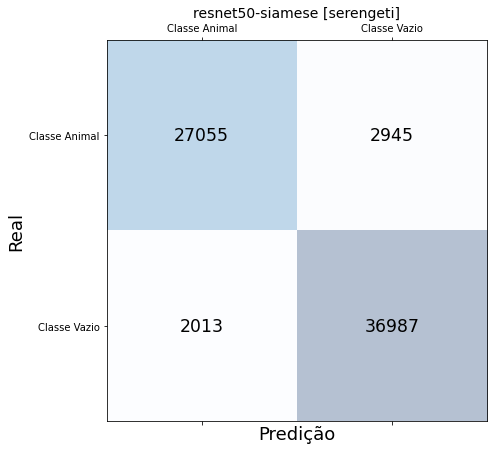

---------> CONFUSION MATRIX - MODEL: resnet50 [serengeti]


/tmp/ipykernel_4453/1262082654.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+alpha)
/tmp/ipykernel_4453/1262082654.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+alpha)


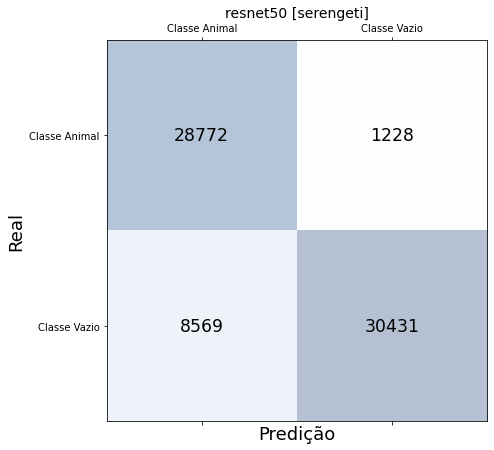

---------> CONFUSION MATRIX - MODEL: efficientnetb0-siamese [serengeti]


/tmp/ipykernel_4453/1262082654.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+alpha)
/tmp/ipykernel_4453/1262082654.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+alpha)


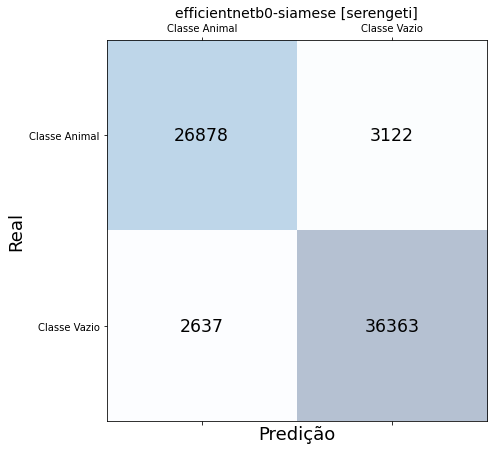

/tmp/ipykernel_4453/1262082654.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+alpha)
/tmp/ipykernel_4453/1262082654.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+alpha)


---------> CONFUSION MATRIX - MODEL: efficientnetb0 [serengeti]


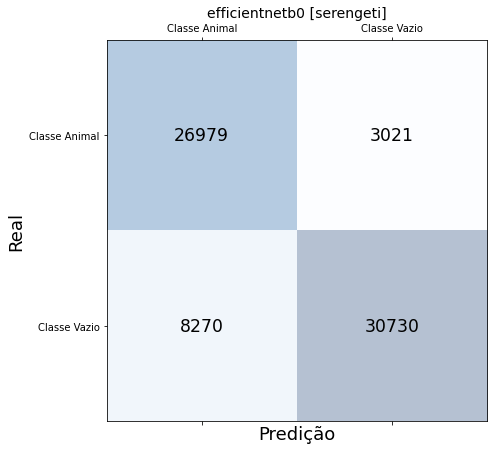

---------> CONFUSION MATRIX - MODEL: mobilenetv2-siamese [caltech]


/tmp/ipykernel_4453/1262082654.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+alpha)
/tmp/ipykernel_4453/1262082654.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+alpha)


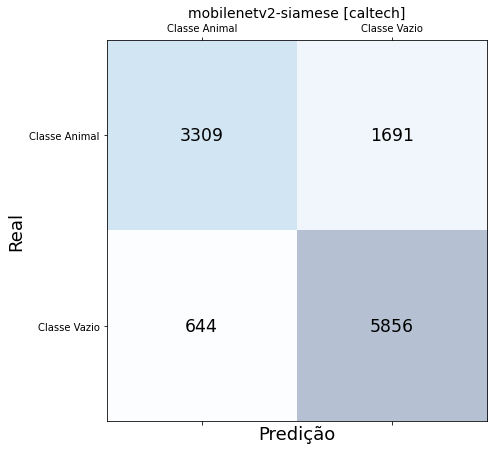

---------> CONFUSION MATRIX - MODEL: mobilenetv2 [caltech]


/tmp/ipykernel_4453/1262082654.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+alpha)
/tmp/ipykernel_4453/1262082654.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+alpha)


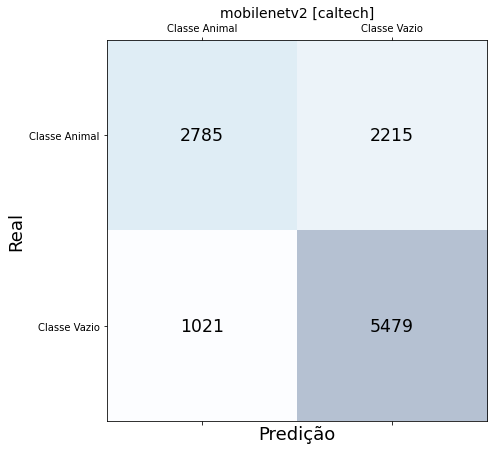

---------> CONFUSION MATRIX - MODEL: resnet50-siamese [caltech]


/tmp/ipykernel_4453/1262082654.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+alpha)
/tmp/ipykernel_4453/1262082654.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+alpha)


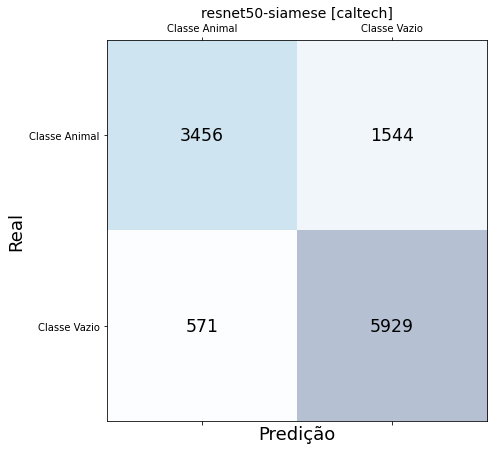

---------> CONFUSION MATRIX - MODEL: resnet50 [caltech]


/tmp/ipykernel_4453/1262082654.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+alpha)
/tmp/ipykernel_4453/1262082654.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+alpha)


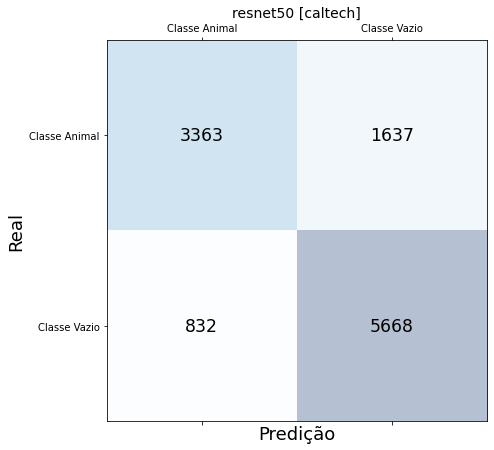

---------> CONFUSION MATRIX - MODEL: efficientnetb0-siamese [caltech]


/tmp/ipykernel_4453/1262082654.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+alpha)
/tmp/ipykernel_4453/1262082654.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+alpha)


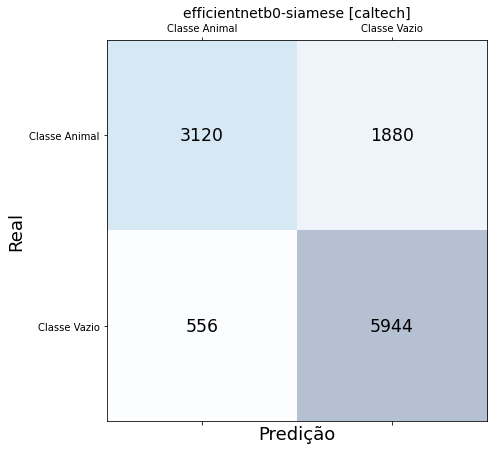

---------> CONFUSION MATRIX - MODEL: efficientnetb0 [caltech]


/tmp/ipykernel_4453/1262082654.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+alpha)
/tmp/ipykernel_4453/1262082654.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+alpha)


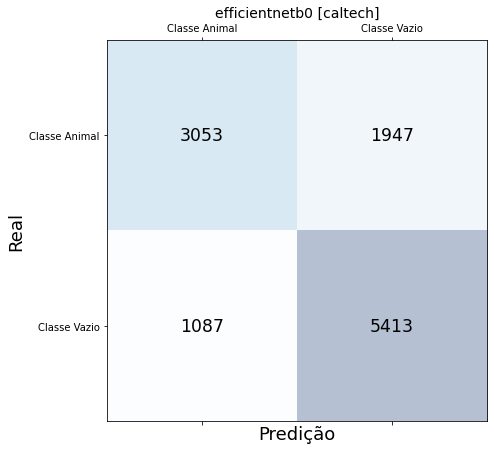

---------> CONFUSION MATRIX - MODEL: mobilenetv2-siamese [wcs]


/tmp/ipykernel_4453/1262082654.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+alpha)
/tmp/ipykernel_4453/1262082654.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+alpha)


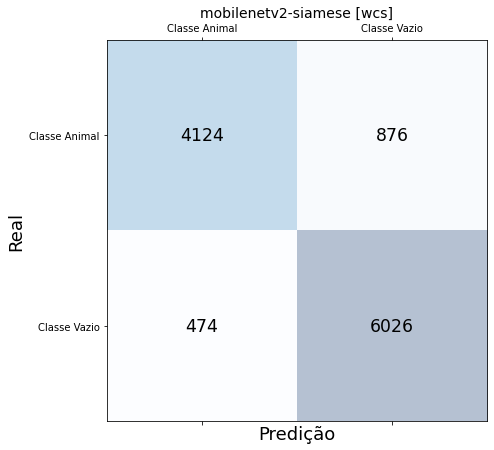

---------> CONFUSION MATRIX - MODEL: mobilenetv2 [wcs]


/tmp/ipykernel_4453/1262082654.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+alpha)
/tmp/ipykernel_4453/1262082654.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+alpha)


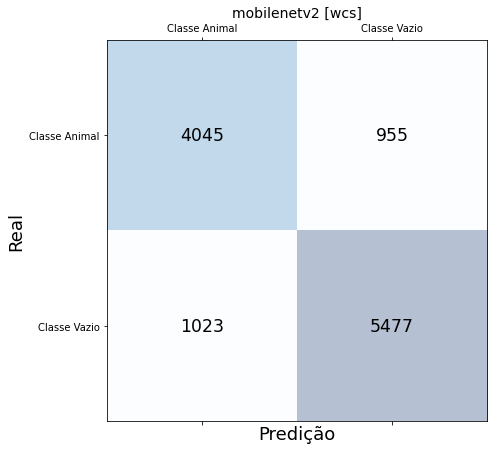

---------> CONFUSION MATRIX - MODEL: resnet50-siamese [wcs]


/tmp/ipykernel_4453/1262082654.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+alpha)
/tmp/ipykernel_4453/1262082654.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+alpha)


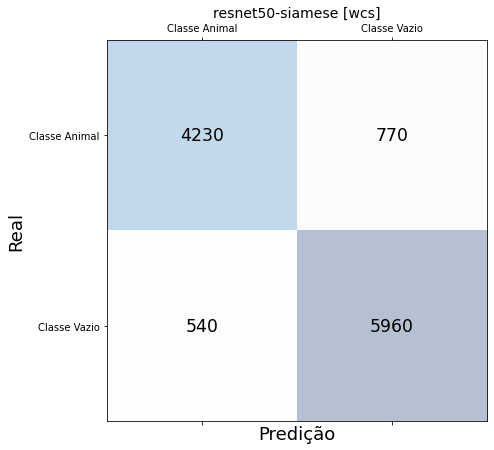

---------> CONFUSION MATRIX - MODEL: resnet50 [wcs]


/tmp/ipykernel_4453/1262082654.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+alpha)
/tmp/ipykernel_4453/1262082654.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+alpha)


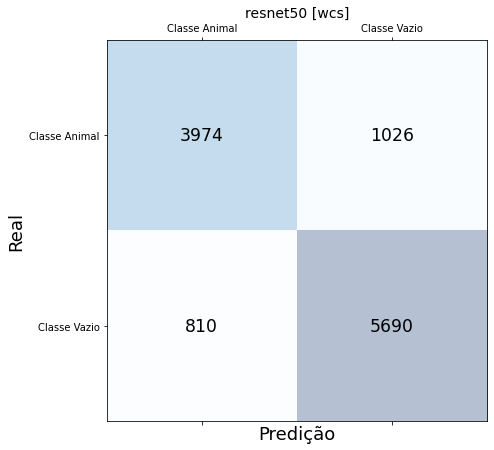

---------> CONFUSION MATRIX - MODEL: efficientnetb0-siamese [wcs]


/tmp/ipykernel_4453/1262082654.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+alpha)
/tmp/ipykernel_4453/1262082654.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+alpha)


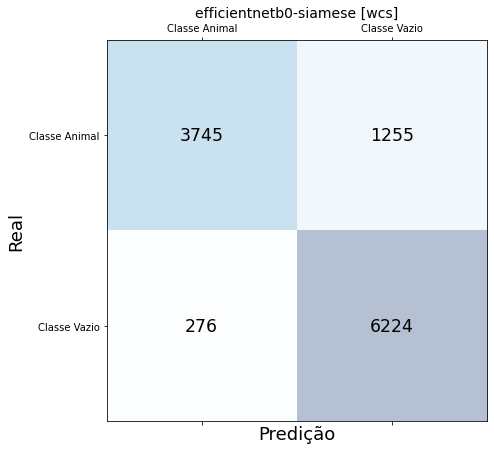

---------> CONFUSION MATRIX - MODEL: efficientnetb0 [wcs]


/tmp/ipykernel_4453/1262082654.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+alpha)
/tmp/ipykernel_4453/1262082654.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+alpha)


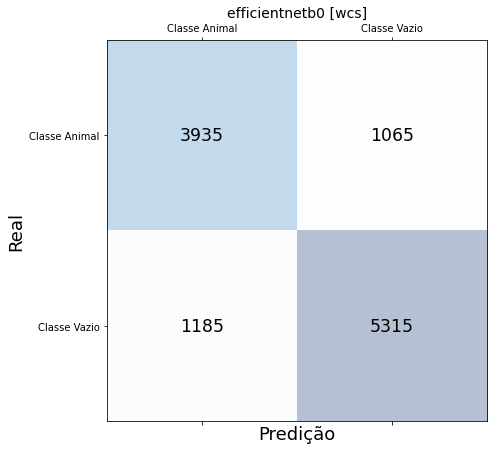

In [13]:
confusion_matrix_evaluation(models)